# comparing models behavior with participants behavior

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["OMP_NUM_THREADS"] = "1"
import seaborn as sns 
import ast
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import pearsonr
from statsmodels.stats.multitest import fdrcorrection
import warnings
warnings.filterwarnings("ignore")


In [2]:
output_dir = r"15_RL_agent_TDlearn_output_behavior_softmax"
os.makedirs(output_dir, exist_ok=True)


folder_path_participants = 'data_risk_added_epileptic'
folder_path_numbers = '12_RL_agent_TDlearn_output_softmax/model_behavior'
folder_path_colors_numbers = '13_RL_agent_TDlearn_output_softmax/model_behavior'


df_participants = []
df_numbers = []
df_colors_numbers = []


distributions_map = { "uniform": 0, "low": 1,  "high": 2}
actions = { "arrowdown": 0, "arrowup": 1}

def find_matching_csv(folder_path, df_list):
            for csv_file in os.listdir(folder_path):
                if clean_name in csv_file and csv_file.endswith('.csv'):
                    csv_path = os.path.join(folder_path, csv_file)
                    df_csv = pd.read_csv(csv_path)
                    df_list.append(df_csv)





for file_name in os.listdir(folder_path_participants):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path_participants, file_name)
        df = pd.read_csv(file_path)
        df = df[df['outcome'].str.lower() != 'na'].reset_index(drop=True) 
        df_participants.append(df)

        clean_name = file_name.removeprefix("task_data_").removesuffix(".csv")


        find_matching_csv(folder_path_numbers, df_numbers)
        find_matching_csv(folder_path_colors_numbers, df_colors_numbers)


In [3]:
df_participants[2].head(5)

,arrowRT,distribution,interTrialInterval,outcome,myCard,yourCard,spaceRT,totalReward,trialIndex,trialType,choice,block,timeoutRepeat,is_within_IQR,risk
0,2135,uniform,835,win,4,7,14079,10.5,0,response,arrowdown,1,0,0,0.375
1,1203,uniform,926,win,9,4,1804,11,1,response,arrowup,1,0,1,0.000
2,1035,uniform,934,win,1,9,766,11.5,2,response,arrowdown,1,0,1,0.000
3,827,uniform,991,lose,2,1,1189,11,3,response,arrowdown,1,0,1,0.125
4,1306,uniform,970,win,9,3,1887,11.5,4,response,arrowup,1,0,1,0.000


In [4]:
df_numbers[2].head()

,model_choices,participant_choices,model_total_reward,participant_total_reward,q_val
0,1,0,9.5,10.5,"[[-0.005470631663443085, -0.000671831958668449..."
1,0,1,9.0,11.0,"[[-0.005470631663443085, -0.000671831958668449..."
2,1,0,8.5,11.5,"[[0.026656247803119665, -0.000671831958668449]..."
3,1,0,9.0,11.0,"[[0.026656247803119665, -0.000671831958668449]..."
4,0,1,8.5,11.5,"[[0.026656247803119665, -0.000671831958668449]..."


In [5]:
df_colors_numbers[2].head(5)

,model_choices,participant_choices,model_total_reward,participant_total_reward,q_val
0,1,0,9.5,10.5,"[[[-0.01962952508513846, -0.001481473591331204..."
1,0,1,9.0,11.0,"[[[-0.01962952508513846, -0.001481473591331204..."
2,0,0,9.5,11.5,"[[[0.055662128486895696, -0.001481473591331204..."
3,1,0,10.0,11.0,"[[[0.055662128486895696, -0.001481473591331204..."
4,1,1,10.5,11.5,"[[[0.055662128486895696, -0.001481473591331204..."


# q-val trends colors model:
I wanna find delta_q vals for arrow up and arrowdown.
 each q_val_number_dist_choice column has q val matrices that are 3 x 2. For 3 uniform, low, high distributions and arrow down and arrow up actions. this is the map from code 11:

distributions_map = { "uniform": 0, "low": 1,  "high": 2}

actions = { "arrowdown": 0, "arrowup": 1}

# attention: I'm looking at q-val (arrowup) - q-val (arrow down)

### first we need to do some preprocessing.

# q-val trends number model:
I wanna find delta_q vals for arrow up and arrowdown.
 each q_val_number_dist_choice column has q val matrices that are 9x2. 9 numbers and 2 actions: arrow down and arrow up actions.
 remembers that numbers are from 1 to 9, but indices are from 0 8 in q val.

 # preprocessing:

In [6]:
down_up_participant_choice = []
delta_q_val_1 = []
delta_q_val_2 = []
delta_q_val_3 = []
delta_q_val_4 = []
delta_q_val_5 = []
delta_q_val_6 = []
delta_q_val_7 = []
delta_q_val_8 = []
delta_q_val_9 = []

for df in df_numbers:
    temp_vec = np.array(df['participant_choices'], dtype=float)

    temp_vec[temp_vec == 0] = -0.5
    temp_vec[temp_vec == 1] = 0.5
    down_up_participant_choice.append(temp_vec)

    delta_1 = []
    delta_2 = []
    delta_3 = []
    delta_4 = []
    delta_5 = []
    delta_6 = []
    delta_7 = []
    delta_8 = []
    delta_9 = []
    
    temp_df = df['q_val']
    for q_vals in temp_df:
        
        temp_vec2 = np.array(ast.literal_eval(q_vals)) 
        delta = temp_vec2[:, actions["arrowup"]] - temp_vec2[:, actions["arrowdown"]]
        delta_1.append(delta[0])
        delta_2.append(delta[1])
        delta_3.append(delta[2])
        delta_4.append(delta[3])
        delta_5.append(delta[4])
        delta_6.append(delta[5])
        delta_7.append(delta[6])
        delta_8.append(delta[7])
        delta_9.append(delta[8])
        
        

    delta_q_val_1.append(delta_1)
    delta_q_val_2.append(delta_2)
    delta_q_val_3.append(delta_3)
    delta_q_val_4.append(delta_4)
    delta_q_val_5.append(delta_5)
    delta_q_val_6.append(delta_6)
    delta_q_val_7.append(delta_7)
    delta_q_val_8.append(delta_8)
    delta_q_val_9.append(delta_9)
        
    


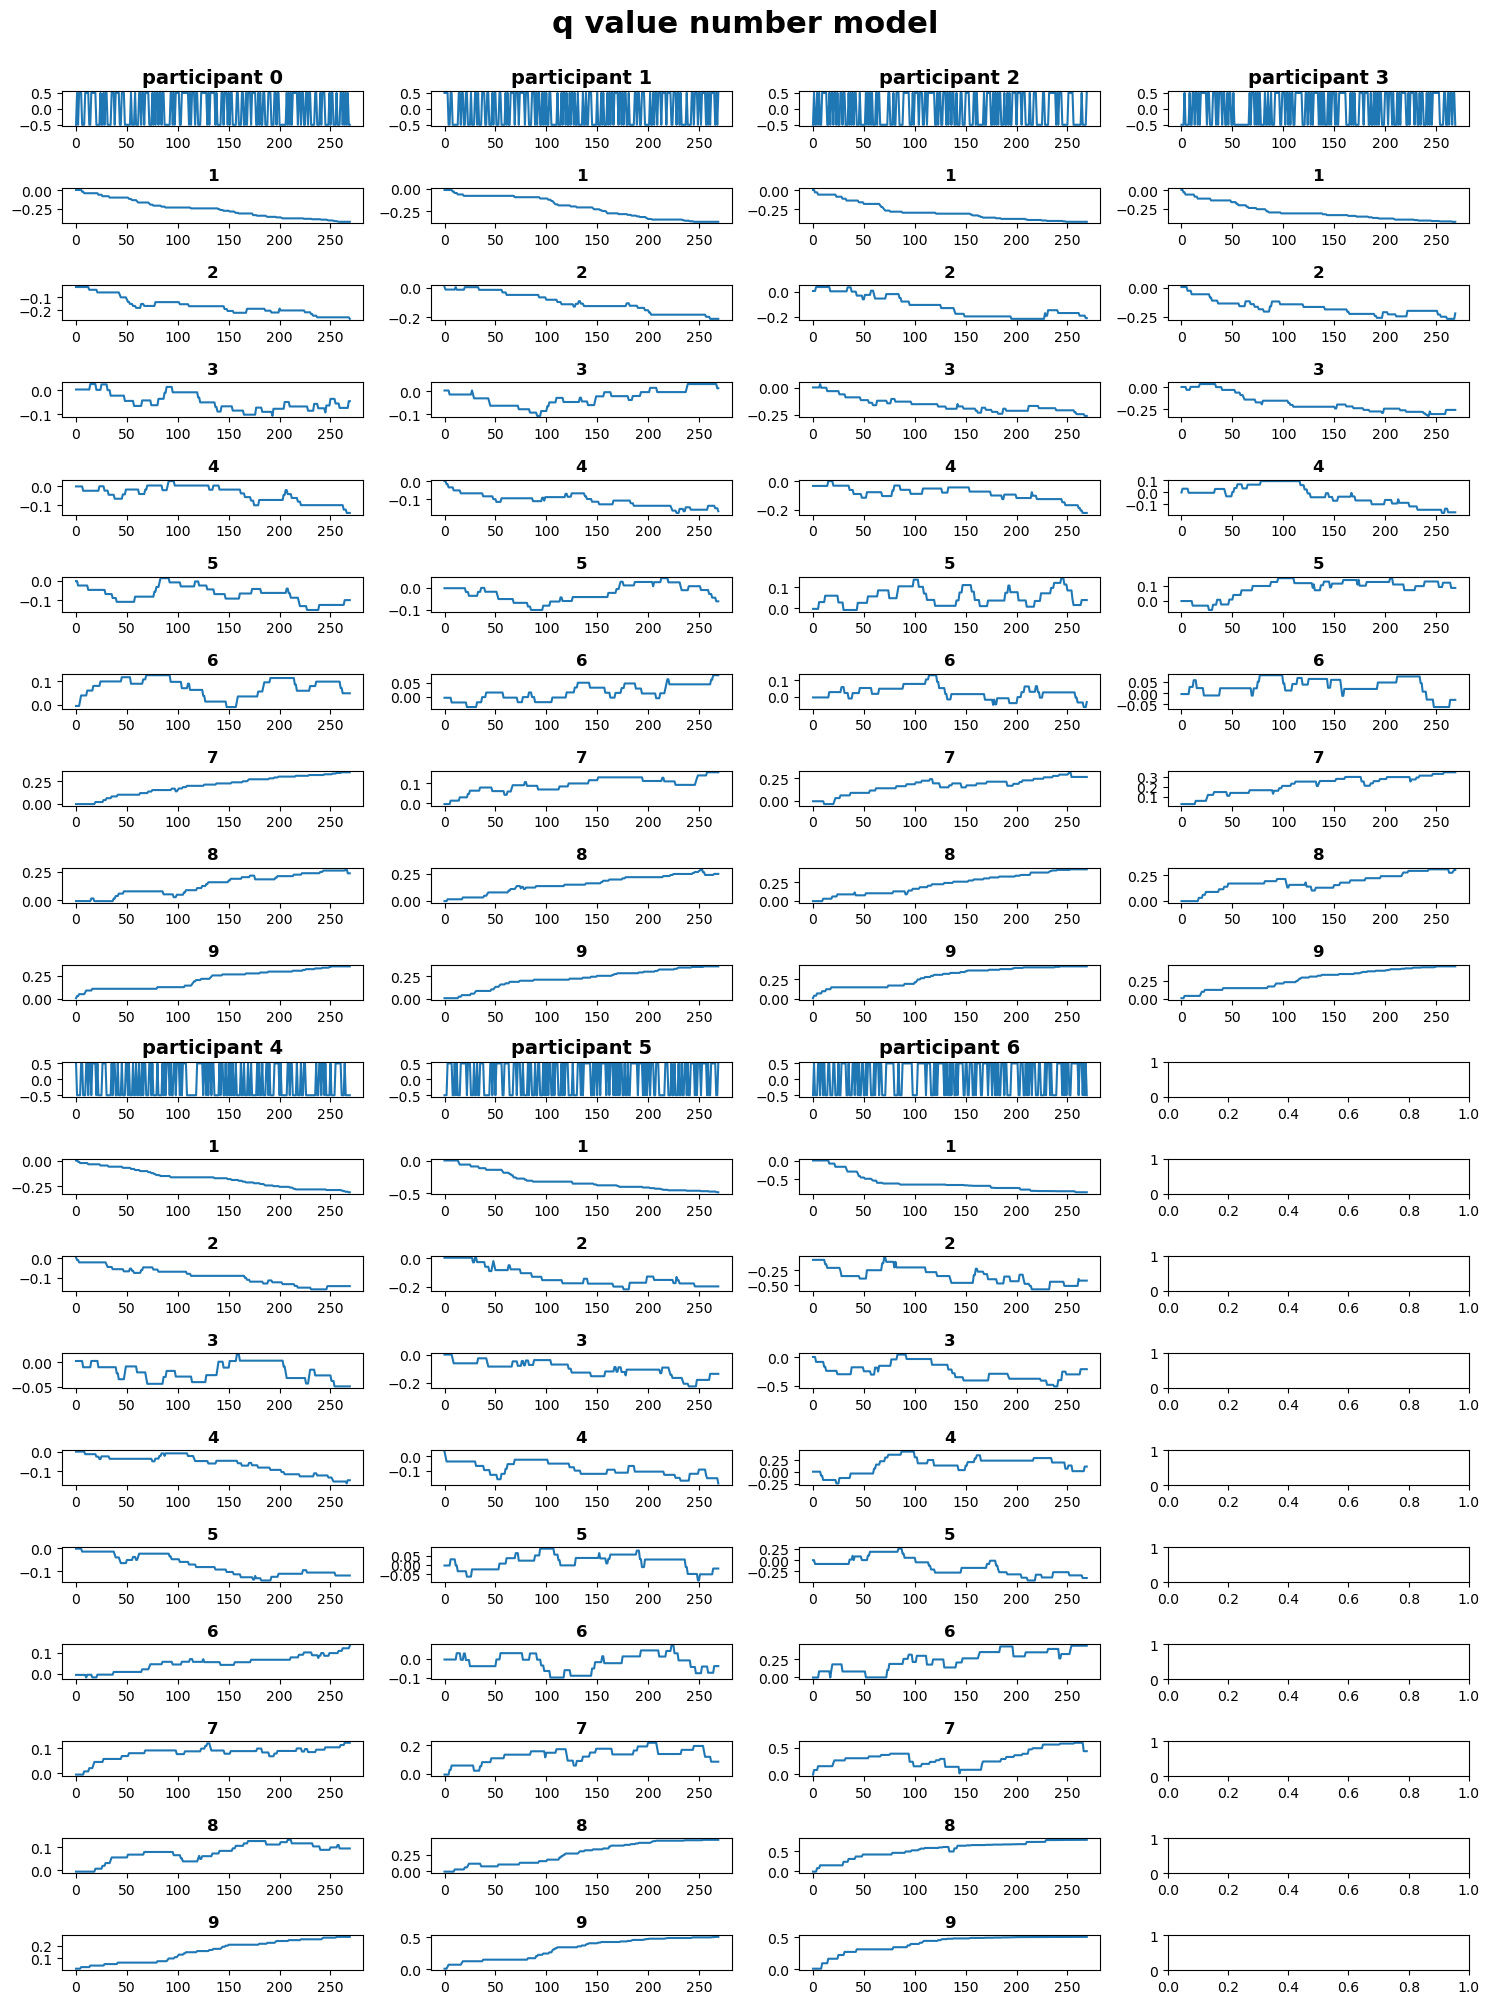

In [7]:
num_participants = len(df_participants)
trial_num = len(df_participants[0])

fig, axes = plt.subplots(nrows=2 * 10, ncols=4, figsize=(15, 20))

axes = np.array(axes).flatten()

vector_data = [down_up_participant_choice, delta_q_val_1, delta_q_val_2, 
               delta_q_val_3, delta_q_val_4, delta_q_val_5, delta_q_val_6, 
               delta_q_val_7, delta_q_val_8, delta_q_val_9]

x = np.arange(trial_num)
# color_palette = ['black', 'gray', 'orange', 'green', 'blue', 'red', 'purple', 'brown', 'pink', 'cyan']

for i in range(num_participants):
    col = i % 4  
    row_start = (i // 4) * 10  # startinggggggg row for this participant (now 10 subplots per participant)

    for j in range(10):  
        ax_index = (row_start + j) * 4 + col  #  index for this subplot
        ax = axes[ax_index]

        vec = vector_data[j][i]  #  the j th vector for participant i
        
        ax.plot(x, vec)

        # have title on the top-most subplot for each participant
        if j == 0:
            ax.set_title(f'participant {i}', fontsize=14, fontweight='bold') 
        else:
            ax.set_title(f'{j}', fontsize=12, fontweight='bold') 

fig.suptitle('q value number model', fontsize=22, fontweight='bold', y=1)
plt.tight_layout()

# Save figure
filename = os.path.join(output_dir, "q_val_number.pdf")
plt.savefig(filename, format='pdf')

# plt.close()


# numbers model delta q val and choices correlations

In [8]:
down_up_participant_choice = np.array(down_up_participant_choice)

delta_q_val_1 = np.array(delta_q_val_1)
delta_q_val_2 = np.array(delta_q_val_2)
delta_q_val_3 = np.array(delta_q_val_3)
delta_q_val_4 = np.array(delta_q_val_4)
delta_q_val_5 = np.array(delta_q_val_5)
delta_q_val_6 = np.array(delta_q_val_6)
delta_q_val_7 = np.array(delta_q_val_7)
delta_q_val_8 = np.array(delta_q_val_8)
delta_q_val_9 = np.array(delta_q_val_9)

num_participants = down_up_participant_choice.shape[0]

# Correlation and p-value arrays
correlations_numbers = np.zeros((num_participants, 9))
correlations_numbers_pval = np.zeros((num_participants, 9))

# Compute correlations and p-values
for i in range(num_participants):
    corr, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_1[i, :])
    correlations_numbers[i, 0] = corr
    correlations_numbers_pval[i, 0] = pval
    
    corr, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_2[i, :])
    correlations_numbers[i, 1] = corr
    correlations_numbers_pval[i, 1] = pval

    corr, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_3[i, :])
    correlations_numbers[i, 2] = corr
    correlations_numbers_pval[i, 2] = pval

    corr, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_4[i, :])
    correlations_numbers[i, 3] = corr
    correlations_numbers_pval[i, 3] = pval

    corr, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_5[i, :])
    correlations_numbers[i, 4] = corr
    correlations_numbers_pval[i, 4] = pval

    corr, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_6[i, :])
    correlations_numbers[i, 5] = corr
    correlations_numbers_pval[i, 5] = pval

    corr, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_7[i, :])
    correlations_numbers[i, 6] = corr
    correlations_numbers_pval[i, 6] = pval

    corr, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_8[i, :])
    correlations_numbers[i, 7] = corr
    correlations_numbers_pval[i, 7] = pval

    corr, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_9[i, :])
    correlations_numbers[i, 8] = corr
    correlations_numbers_pval[i, 8] = pval

# Transpose so participants match columns
correlations_numbers = correlations_numbers.T
correlations_numbers_pval = correlations_numbers_pval.T

# Create annotation array where p<0.05 is marked with '*'
annots = np.array([
    ["*" if correlations_numbers_pval[row, col] < 0.05 else "" 
     for col in range(num_participants)]
    for row in range(9)
])

plt.figure(figsize=(25, 6))
ax = sns.heatmap(
    correlations_numbers,
    cmap='coolwarm',
    linewidths=0.5,
    xticklabels=[f'p{i+1}' for i in range(num_participants)],
    yticklabels=list(range(1, 10)),
    cbar=True,
    vmin=-0.4,
    vmax=0.4,
    annot=annots,  # Add significance asterisks
    fmt=''         # So they appear as just '*'
)

plt.xlabel("participants")
plt.ylabel("numbers")
plt.title("correlation between Δq-values [q(up)-q(down)] and choice")

filename = os.path.join(output_dir, "correlation_qVal_choice_numbers.pdf")
plt.savefig(filename, format='pdf')

plt.close()


# q-val trends both colors and numbers model:
I wanna find delta_q vals for arrow up and arrowdown. and then find delta q val (up - down)

# preprocessing:

In [9]:
down_up_participant_choice_both = []
delta_q_val_1_both = []
delta_q_val_2_both = []
delta_q_val_3_both = []
delta_q_val_4_both = []
delta_q_val_5_both = []
delta_q_val_6_both = []
delta_q_val_7_both = []
delta_q_val_8_both = []
delta_q_val_9_both = []

for df in df_colors_numbers:
    temp_vec = np.array(df['participant_choices'], dtype=float)
    temp_vec[temp_vec == 0] = -0.5
    temp_vec[temp_vec == 1] = 0.5
    temp_vec = np.stack([temp_vec] * 3, axis=-1)
    # print(np.shape(temp_vec))
    down_up_participant_choice_both.append(temp_vec)

    

    delta_1_both = []
    delta_2_both = []
    delta_3_both = []
    delta_4_both = []
    delta_5_both = []
    delta_6_both = []
    delta_7_both = []
    delta_8_both = []
    delta_9_both = []
    
    temp_df = df['q_val']
    for q_vals in temp_df:
        
        temp_vec2 = np.array(ast.literal_eval(q_vals)) 
        delta = temp_vec2[:, :, actions["arrowup"]].squeeze() - temp_vec2[:, :, actions["arrowdown"]].squeeze()
        delta_1_both.append(delta[0][:])
        delta_2_both.append(delta[1][:])
        delta_3_both.append(delta[2][:])
        delta_4_both.append(delta[3][:])
        delta_5_both.append(delta[4][:])
        delta_6_both.append(delta[5][:])
        delta_7_both.append(delta[6][:])
        delta_8_both.append(delta[7][:])
        delta_9_both.append(delta[8][:])
        
        

    delta_q_val_1_both.append(delta_1_both)
    delta_q_val_2_both.append(delta_2_both)
    delta_q_val_3_both.append(delta_3_both)
    delta_q_val_4_both.append(delta_4_both)
    delta_q_val_5_both.append(delta_5_both)
    delta_q_val_6_both.append(delta_6_both)
    delta_q_val_7_both.append(delta_7_both)
    delta_q_val_8_both.append(delta_8_both)
    delta_q_val_9_both.append(delta_9_both)
        
    


In [10]:
num_participants = len(df_participants)
trial_num = len(df_participants[0])

fig, axes = plt.subplots(nrows=9 * 10, ncols=4, figsize=(15, 100))

axes = np.array(axes).flatten()

vector_data_both = [down_up_participant_choice_both, delta_q_val_1_both, delta_q_val_2_both, 
               delta_q_val_3_both, delta_q_val_4_both, delta_q_val_5_both, delta_q_val_6_both, 
               delta_q_val_7_both, delta_q_val_8_both, delta_q_val_9_both]

x = np.arange(trial_num)
color_palette = [ 'gray', 'orange', 'green']

for i in range(num_participants):
    col = i % 4  
    row_start = (i // 4) * 10  # startinggggggg row for this participant (now 10 subplots per participant)

    for j in range(10):  
        ax_index = (row_start + j) * 4 + col  #  index for this subplot
        ax = axes[ax_index]

        vec = np.array(vector_data_both[j][i])
        
        ax.plot(x, vec[:,distributions_map["uniform"]], color = 'gray')
        ax.plot(x, vec[:,distributions_map["low"]], color = 'orange')
        ax.plot(x, vec[:,distributions_map["high"]], color = 'green')

        # have title on the top-most subplot for each participant
        if j == 0:
            ax.set_title(f'participant {i}', fontsize=14, fontweight='bold') 
        else:
            ax.set_title(f'{j}', fontsize=12, fontweight='bold') 

fig.suptitle('q value both', fontsize=22, fontweight='bold', y=1)
plt.tight_layout()

# Save figure
filename = os.path.join(output_dir, "q_val_both.pdf")
plt.savefig(filename, format='pdf')

plt.close()


# BOTH model delta q val and choices correlations

In [11]:

down_up_participant_choice = np.array(down_up_participant_choice)

delta_q_val_1_both = np.array(delta_q_val_1_both)
delta_q_val_2_both = np.array(delta_q_val_2_both)
delta_q_val_3_both = np.array(delta_q_val_3_both)
delta_q_val_4_both = np.array(delta_q_val_4_both)
delta_q_val_5_both = np.array(delta_q_val_5_both)
delta_q_val_6_both = np.array(delta_q_val_6_both)
delta_q_val_7_both = np.array(delta_q_val_7_both)
delta_q_val_8_both = np.array(delta_q_val_8_both)
delta_q_val_9_both = np.array(delta_q_val_9_both)

num_participants = down_up_participant_choice.shape[0]

# Keep the same shape as before for correlations_both
correlations_both = np.zeros((num_participants, 9, len(distributions_map)))

# Add a matching array for p-values
pvals_both = np.zeros((num_participants, 9, len(distributions_map)))

for i in range(num_participants):
    # number 1
    corr = np.corrcoef(down_up_participant_choice[i, :], delta_q_val_1_both[i, :, distributions_map["uniform"]])[0, 1]
    correlations_both[i, 0, distributions_map["uniform"]] = corr
    _, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_1_both[i, :, distributions_map["uniform"]])
    pvals_both[i, 0, distributions_map["uniform"]] = pval

    corr = np.corrcoef(down_up_participant_choice[i, :], delta_q_val_1_both[i, :, distributions_map["low"]])[0, 1]
    correlations_both[i, 0, distributions_map["low"]] = corr
    _, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_1_both[i, :, distributions_map["low"]])
    pvals_both[i, 0, distributions_map["low"]] = pval

    corr = np.corrcoef(down_up_participant_choice[i, :], delta_q_val_1_both[i, :, distributions_map["high"]])[0, 1]
    correlations_both[i, 0, distributions_map["high"]] = corr
    _, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_1_both[i, :, distributions_map["high"]])
    pvals_both[i, 0, distributions_map["high"]] = pval

    # number 2
    corr = np.corrcoef(down_up_participant_choice[i, :], delta_q_val_2_both[i, :, distributions_map["uniform"]])[0, 1]
    correlations_both[i, 1, distributions_map["uniform"]] = corr
    _, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_2_both[i, :, distributions_map["uniform"]])
    pvals_both[i, 1, distributions_map["uniform"]] = pval

    corr = np.corrcoef(down_up_participant_choice[i, :], delta_q_val_2_both[i, :, distributions_map["low"]])[0, 1]
    correlations_both[i, 1, distributions_map["low"]] = corr
    _, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_2_both[i, :, distributions_map["low"]])
    pvals_both[i, 1, distributions_map["low"]] = pval

    corr = np.corrcoef(down_up_participant_choice[i, :], delta_q_val_2_both[i, :, distributions_map["high"]])[0, 1]
    correlations_both[i, 1, distributions_map["high"]] = corr
    _, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_2_both[i, :, distributions_map["high"]])
    pvals_both[i, 1, distributions_map["high"]] = pval

    # number 3
    corr = np.corrcoef(down_up_participant_choice[i, :], delta_q_val_3_both[i, :, distributions_map["uniform"]])[0, 1]
    correlations_both[i, 2, distributions_map["uniform"]] = corr
    _, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_3_both[i, :, distributions_map["uniform"]])
    pvals_both[i, 2, distributions_map["uniform"]] = pval

    corr = np.corrcoef(down_up_participant_choice[i, :], delta_q_val_3_both[i, :, distributions_map["low"]])[0, 1]
    correlations_both[i, 2, distributions_map["low"]] = corr
    _, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_3_both[i, :, distributions_map["low"]])
    pvals_both[i, 2, distributions_map["low"]] = pval

    corr = np.corrcoef(down_up_participant_choice[i, :], delta_q_val_3_both[i, :, distributions_map["high"]])[0, 1]
    correlations_both[i, 2, distributions_map["high"]] = corr
    _, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_3_both[i, :, distributions_map["high"]])
    pvals_both[i, 2, distributions_map["high"]] = pval

    # number 4
    corr = np.corrcoef(down_up_participant_choice[i, :], delta_q_val_4_both[i, :, distributions_map["uniform"]])[0, 1]
    correlations_both[i, 3, distributions_map["uniform"]] = corr
    _, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_4_both[i, :, distributions_map["uniform"]])
    pvals_both[i, 3, distributions_map["uniform"]] = pval

    corr = np.corrcoef(down_up_participant_choice[i, :], delta_q_val_4_both[i, :, distributions_map["low"]])[0, 1]
    correlations_both[i, 3, distributions_map["low"]] = corr
    _, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_4_both[i, :, distributions_map["low"]])
    pvals_both[i, 3, distributions_map["low"]] = pval

    corr = np.corrcoef(down_up_participant_choice[i, :], delta_q_val_4_both[i, :, distributions_map["high"]])[0, 1]
    correlations_both[i, 3, distributions_map["high"]] = corr
    _, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_4_both[i, :, distributions_map["high"]])
    pvals_both[i, 3, distributions_map["high"]] = pval

    # number 5
    corr = np.corrcoef(down_up_participant_choice[i, :], delta_q_val_5_both[i, :, distributions_map["uniform"]])[0, 1]
    correlations_both[i, 4, distributions_map["uniform"]] = corr
    _, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_5_both[i, :, distributions_map["uniform"]])
    pvals_both[i, 4, distributions_map["uniform"]] = pval

    corr = np.corrcoef(down_up_participant_choice[i, :], delta_q_val_5_both[i, :, distributions_map["low"]])[0, 1]
    correlations_both[i, 4, distributions_map["low"]] = corr
    _, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_5_both[i, :, distributions_map["low"]])
    pvals_both[i, 4, distributions_map["low"]] = pval

    corr = np.corrcoef(down_up_participant_choice[i, :], delta_q_val_5_both[i, :, distributions_map["high"]])[0, 1]
    correlations_both[i, 4, distributions_map["high"]] = corr
    _, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_5_both[i, :, distributions_map["high"]])
    pvals_both[i, 4, distributions_map["high"]] = pval

    # number 6
    corr = np.corrcoef(down_up_participant_choice[i, :], delta_q_val_6_both[i, :, distributions_map["uniform"]])[0, 1]
    correlations_both[i, 5, distributions_map["uniform"]] = corr
    _, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_6_both[i, :, distributions_map["uniform"]])
    pvals_both[i, 5, distributions_map["uniform"]] = pval

    corr = np.corrcoef(down_up_participant_choice[i, :], delta_q_val_6_both[i, :, distributions_map["low"]])[0, 1]
    correlations_both[i, 5, distributions_map["low"]] = corr
    _, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_6_both[i, :, distributions_map["low"]])
    pvals_both[i, 5, distributions_map["low"]] = pval

    corr = np.corrcoef(down_up_participant_choice[i, :], delta_q_val_6_both[i, :, distributions_map["high"]])[0, 1]
    correlations_both[i, 5, distributions_map["high"]] = corr
    _, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_6_both[i, :, distributions_map["high"]])
    pvals_both[i, 5, distributions_map["high"]] = pval

    # number 7
    corr = np.corrcoef(down_up_participant_choice[i, :], delta_q_val_7_both[i, :, distributions_map["uniform"]])[0, 1]
    correlations_both[i, 6, distributions_map["uniform"]] = corr
    _, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_7_both[i, :, distributions_map["uniform"]])
    pvals_both[i, 6, distributions_map["uniform"]] = pval

    corr = np.corrcoef(down_up_participant_choice[i, :], delta_q_val_7_both[i, :, distributions_map["low"]])[0, 1]
    correlations_both[i, 6, distributions_map["low"]] = corr
    _, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_7_both[i, :, distributions_map["low"]])
    pvals_both[i, 6, distributions_map["low"]] = pval

    corr = np.corrcoef(down_up_participant_choice[i, :], delta_q_val_7_both[i, :, distributions_map["high"]])[0, 1]
    correlations_both[i, 6, distributions_map["high"]] = corr
    _, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_7_both[i, :, distributions_map["high"]])
    pvals_both[i, 6, distributions_map["high"]] = pval

    # number 8
    corr = np.corrcoef(down_up_participant_choice[i, :], delta_q_val_8_both[i, :, distributions_map["uniform"]])[0, 1]
    correlations_both[i, 7, distributions_map["uniform"]] = corr
    _, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_8_both[i, :, distributions_map["uniform"]])
    pvals_both[i, 7, distributions_map["uniform"]] = pval

    corr = np.corrcoef(down_up_participant_choice[i, :], delta_q_val_8_both[i, :, distributions_map["low"]])[0, 1]
    correlations_both[i, 7, distributions_map["low"]] = corr
    _, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_8_both[i, :, distributions_map["low"]])
    pvals_both[i, 7, distributions_map["low"]] = pval

    corr = np.corrcoef(down_up_participant_choice[i, :], delta_q_val_8_both[i, :, distributions_map["high"]])[0, 1]
    correlations_both[i, 7, distributions_map["high"]] = corr
    _, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_8_both[i, :, distributions_map["high"]])
    pvals_both[i, 7, distributions_map["high"]] = pval

    # number 9
    corr = np.corrcoef(down_up_participant_choice[i, :], delta_q_val_9_both[i, :, distributions_map["uniform"]])[0, 1]
    correlations_both[i, 8, distributions_map["uniform"]] = corr
    _, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_9_both[i, :, distributions_map["uniform"]])
    pvals_both[i, 8, distributions_map["uniform"]] = pval

    corr = np.corrcoef(down_up_participant_choice[i, :], delta_q_val_9_both[i, :, distributions_map["low"]])[0, 1]
    correlations_both[i, 8, distributions_map["low"]] = corr
    _, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_9_both[i, :, distributions_map["low"]])
    pvals_both[i, 8, distributions_map["low"]] = pval

    corr = np.corrcoef(down_up_participant_choice[i, :], delta_q_val_9_both[i, :, distributions_map["high"]])[0, 1]
    correlations_both[i, 8, distributions_map["high"]] = corr
    _, pval = pearsonr(down_up_participant_choice[i, :], delta_q_val_9_both[i, :, distributions_map["high"]])
    pvals_both[i, 8, distributions_map["high"]] = pval



fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))
labels = ['uniform', 'low', 'high']

for corr_plot in range(3):
    ax = axes[corr_plot]
    correlations = correlations_both[:, :, corr_plot].T  
    
    # Create an annotation array of asterisks where p < 0.05
    annots = np.empty((9, num_participants), dtype=object)
    for row in range(9):
        for col in range(num_participants):
            if pvals_both[col, row, corr_plot] < 0.05:
                annots[row, col] = '*'
            else:
                annots[row, col] = ''

    sns.heatmap(
        correlations, ax=ax, cmap='coolwarm', linewidths=0.5,
        xticklabels=[f'p{i+1}' for i in range(num_participants)],
        yticklabels=list(range(1, 10)), cbar=True, vmin=-0.4, vmax=0.4,
        annot=annots, fmt=""  # annotations = '*' for p<0.05
    )

    if corr_plot == 1:
        ax.set_ylabel("numbers", fontsize=12, fontweight='bold')
    if corr_plot == 2:
        ax.set_xlabel("participants", fontsize=12, fontweight='bold')

    ax.set_title(f"{labels[corr_plot]}")

fig.suptitle('correlation between Δq-values [q(up)-q(down)] and choice', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()

filename = os.path.join(output_dir, "correlation_qVal_choice_both.pdf")
plt.savefig(filename, format='pdf')
plt.close()
